# [EX6] House Price Prediction

* 목표    
 집의 가격을 예측하기
* 설명    
 회귀문제

## 1. 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

## 2. 데이터 경로 지정

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data3'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')  # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data3/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data3/test.csv


## 3. 데이터 불러오기

In [3]:
train = pd.read_csv(train_data_path) # 학습 데이터를 train 변수에 저장
test = pd.read_csv(test_data_path) # 테스터 데이터를 test 변수에 저장
print('train data dim : {}'.format(train.shape)) # price 컬럼 있음
print('test data dim : {}'.format(test.shape)) # price 컬럼 없음

train data dim : (15035, 21)
test data dim : (6468, 20)


In [4]:
train.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## 2. 데이터 전처리

### 1) 학습 데이터와 테스트 데이터 합치기

In [6]:
train_len = len(train)
alldata = pd.concat((train, test), axis=0)

print('alldata :', len(alldata))

alldata : 21503


In [7]:
alldata.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2) target 컬럼 저장

In [8]:
y = train['price'] # target인 price 컬럼을 y 변수에 넣어둠

print('train 길이 :', len(train))
print('y 길이 :', len(y))

train 길이 : 15035
y 길이 : 15035


### 2) id, price 컬럼 제거

In [9]:
alldata2 = alldata.drop(columns = ['id', 'price']) # id, price 컬럼 삭제

print('id, price 컬럼 삭제 전 :', alldata.shape)
print('id, price 컬럼 삭제 전 :', alldata2.shape)

id, price 컬럼 삭제 전 : (21503, 21)
id, price 컬럼 삭제 전 : (21503, 19)


### 3) 데이터 형태, 타입 변경

#### 1) 컬럼 타입 확인

In [10]:
# 모델 학습을 위해 오브젝트는 정수로 변환
alldata2.dtypes

date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

#### 2) date 컬럼 형태, 타입 변경

In [11]:
# 연/월 데이터 형식으로 만든 뒤, 정수(int)형 데이터로 처리
alldata2['date'] = alldata2['date'].apply(lambda i: i[:6]).astype(int)

alldata2.head(5)

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 4) 결측치 확인

#### 4_1) 결측치 시각화

<AxesSubplot:>

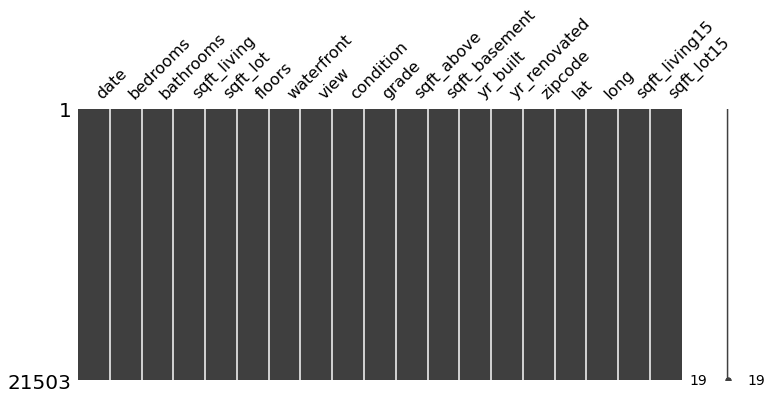

In [12]:
# 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옴
msno.matrix(alldata2, figsize=(12,5))

In [13]:
#### 4_2) 결측치 개수 확인

In [14]:
alldata2.isnull().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

결측치가 없음 확인

## 5) alldata2 로그 스케일링(log1p)

### 5_1) alldata2 컬럼 확인

In [15]:
# alldata 컬럼 확인
print(alldata2.columns)
print(len(alldata2.columns))

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
19


### 5_2) alldata2 분포 확인

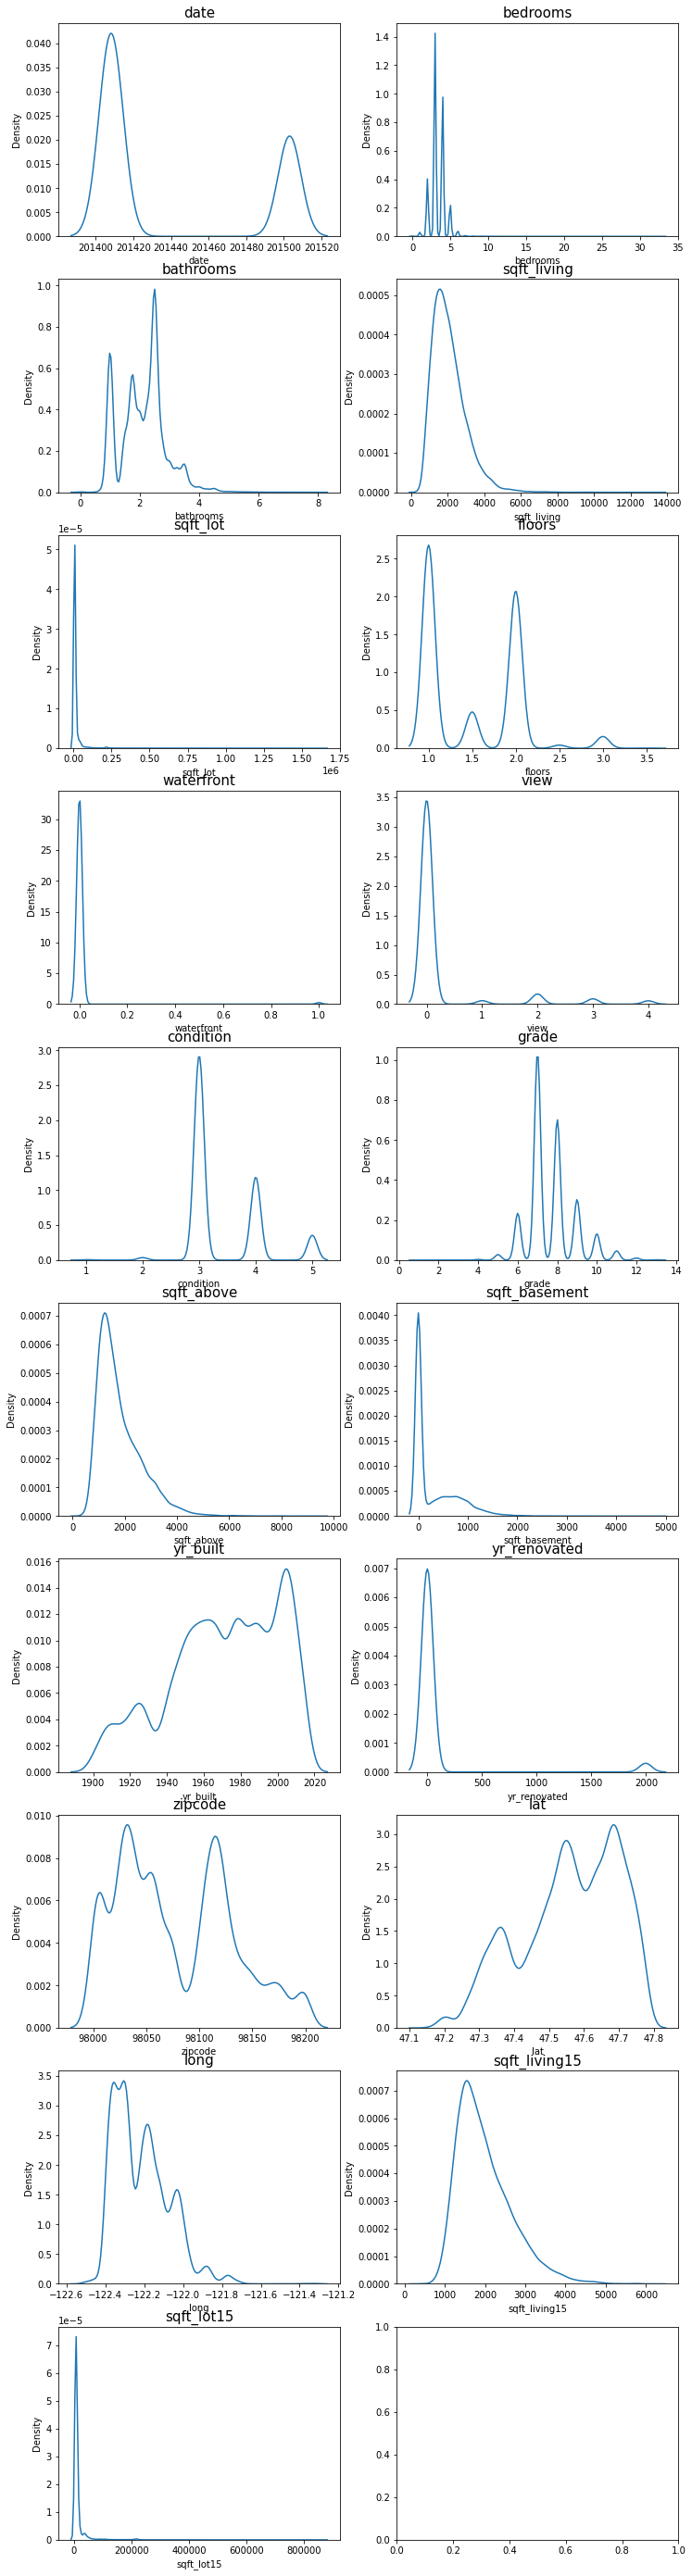

In [16]:
# 19개 컬럼에 대한 그래프 출력
columns = alldata2.columns 

fig, ax = plt.subplots(10, 2, figsize=(12, 50))

count = 0
for row in range(10):
    for col in range(2):
        if count == 19:
            break
        sns.kdeplot(alldata2[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1            

### 5_3) np.log1p() 를 이용하여 정규 분포 변환

In [17]:
# skew_columns 리스트의 컬럼들을 로그 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

# np.log1() : 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수
for c in skew_columns:
    alldata2[c] = np.log1p(alldata2[c].values)

print('success')

success


### 5_4) 정규 분포 변환 시각화 확인

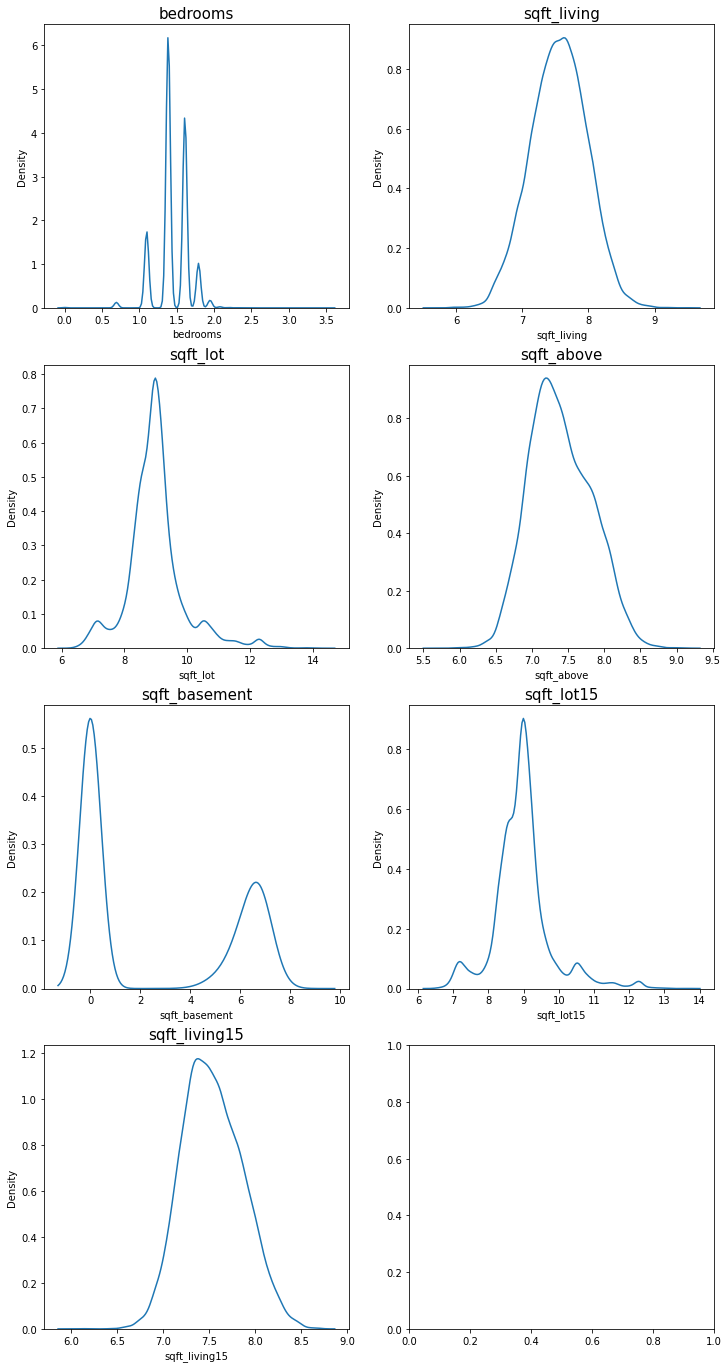

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(alldata2[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

## 6) target 로그 스케일링(log1p)

### 6_1) y 값 확인

In [19]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

### 6_2) alldata2 분포 시각화 확인

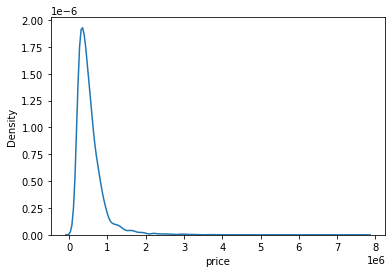

In [20]:
sns.kdeplot(y)
plt.show()

### 6_3) np.log1p() 를 이용하여 정규 분포 변환

In [21]:
y = np.log1p(y)

print('success')

success


### 6_4) 정규 분포 변환 값 확인

In [22]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

### 6_5) 정규 분표 변환 시각화 확인

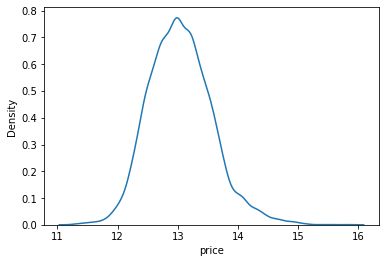

In [23]:
# y에 price 컬럼을 저장해둠
sns.kdeplot(y)
plt.show()

## 7) 데이터 타입 재확인

In [24]:
alldata2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  float64
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  float64
 4   sqft_lot       21503 non-null  float64
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  float64
 11  sqft_basement  21503 non-null  float64
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  float64
 18  sqft_lo

## 8) 데이터 나누기

In [25]:
train2 = alldata2[:len(train)]
test2 = alldata2[len(train):]

print('train data dim : {}'.format(train2.shape)) # price 컬럼 있음
print('test data dim : {}'.format(test2.shape)) # price 컬럼 없음

train data dim : (15035, 19)
test data dim : (6468, 19)


## 9) RMSE 계산 하기

### 9_1) np. expm1 적용 함수 생성

In [26]:
# 이후 exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 적용 하기 위해 함수 생성
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 9_2)  Average Blending(모델 생성 후 저장)

In [27]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

### 9_3) 각 모델별 RMSE 값 얻기

In [28]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        
        #  분리 # Validation
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습 
        model.fit(X_train, y_train) # x_train : 문제, y_train : 답
        
        # 모델이 얼마나 잘 학습했는지 Validation 를 가지고 평가
        y_pred = model.predict(X_test)
        
        # 예측 결과의 rmse 값 저장
        df[model_name] = rmse(y_test, y_pred) # y_test: Validation 에 대한 정답, y_pred : 모델이 예측 한 값
        # 차이를 계산해서 다 합산함. 값이 적을수록 좋음.
        
        # data frame에 저장  # 각 모델에 대한 rmse 값을 저장하는 frame을 만듬
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train2, y)

,RMSE
GradientBoostingRegressor,128370.486911
RandomForestRegressor,125299.591549
LGBMRegressor,111906.268088
XGBRegressor,110319.723794


## 10) Grid search 하기

### 10_1) Grid search 함수 구현

In [29]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

### 10_2) XGBRegressor 하이퍼 파라미터 설정 후 탐색

In [31]:
param_grid = {
    'learning_rate  ' : [0.1, 0.3], # 의사 결정 나무의 깊이
    'max_depth' : [5, 10], # 훈련량 
    'alpha ' : [10],
    'n_estimators ' : [100],
    #'boosting' : [boosting'] 
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train2, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed: 11.1min finished


[00:18:45] WARNING: ../src/learner.cc:541: 
Parameters: { alpha , learning_rate  , n_estimators  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,alpha,learning_rate,max_depth,n_estimators,score,RMSLE
0,10,0.1,5,100,-0.028201,0.167932
2,10,0.3,5,100,-0.028201,0.167932
1,10,0.1,10,100,-0.030476,0.174573
3,10,0.3,10,100,-0.030476,0.174573


### 10_3) 최적 하이퍼 파라미터 모델 학습 & 제출 파일 저장

In [39]:
model = LGBMRegressor(boosting ='goss', learning_rate='0.015', max_depth=7, n_estimators=1600, num_iterations=2000, random_state=random_state)

def save_submission(model, train, y, test, model_name, rmsle=None):
    
    # 모델 학습
    model.fit(train, y) 
    
    # 모델이 잘 학습 헀는지 Validation 으로 평가
    prediction = model.predict(test)
    
    # np.expm1 하여 원래 스케일로 되돌려 줌
    prediction = np.expm1(prediction)
    
    # 제출할 파일 열기
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data3'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 데이터 프레임에 모델이 예측한 값을 덮어 씌우기
    submission['price'] = prediction
    
    # 제출 파일 관리
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [41]:
save_submission(model, train2, y, test2, 'xgboost', rmsle='xx')

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data3/submission_xgboost_RMSLE_xx.csv saved!


## 11) 최종 결과 및 회고

* 최종 결과    
   * Private Score 111695.23052. Public Score 106251.31149    
   * model = LGBMRegressor(boosting ='goss', learning_rate='0.015', max_depth=7, n_estimators=1600, num_iterations=2000, random_state=random_state)

